# Diagonalized Map Making
# An idea form Victor Chabirand
### 1D first trial
### JCH Dec. 2024

In [203]:
# %matplotlib inline
%matplotlib ipympl


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

sz = 10.
plt.rc('figure',figsize=(sz,sz/1.618))
plt.rc('font',size=10)
plt.rc('image', cmap='jet')

# 1. Simulate a simplistic sky on a ring (periodic 1D)

In [293]:
def spec_1_f(ff, pow):
    zz = ff != 0
    s = np.zeros_like(ff)
    s[zz] = np.nan_to_num(np.abs(ff[zz])**(-pow))
    s[~zz] = 0
    return s

def rnd_sky_1d(xpix, args):
    ff = np.fft.fftfreq(len(xpix), xpix[1]-xpix[0])
    rndy = np.random.randn(len(xpix))
    ftyin = np.fft.fft(rndy)
    fty = ftyin*spec_1_f(ff, args[0])
    y = np.real(np.fft.ifft(fty))
    return y

def sinsky(th_deg, args):
    return np.sin(np.radians(th_deg)*args[0])

def create_1d_sky(npix, funct, args):
    xpix = np.linspace(-180, 180, npix)
    truey = funct(xpix, args)
    truey = truey / np.std(truey)
    return xpix, truey

def get_primbeam(th, lam, fwhmprimbeam_150=14.):
    fwhmprim = fwhmprimbeam_150 * lam / (3e8/150e9)
    primbeam = np.exp(-0.5 * th**2 / (fwhmprim/np.sqrt(8*np.log(2)))**2)
    return primbeam

def give_sbcut(th, dx, lam, sqnh, Df=1., detpos=0., fwhmprimbeam_150=14., kmax=2, type='BI'):
    primbeam =  get_primbeam(th, lam, fwhmprimbeam_150=fwhmprimbeam_150)
    theth = th - np.degrees(detpos/Df)
    arg_to_sin = np.pi * dx / lam * np.radians(theth)
    sb = np.zeros(len(arg_to_sin))
    ok = np.sin(arg_to_sin) != 0
    sb[ok] = np.sin(sqnh * arg_to_sin[ok])**2 / np.sin(arg_to_sin[ok])**2
    sb[~ok] = 1
    sb = sb/sqnh**2*primbeam
    fwhmpeak = np.degrees(lam / sqnh / dx)
    thetapeaks = np.degrees(lam / dx)
    allthetapeaks = thetapeaks * (np.arange(2*kmax+1)-kmax) + np.degrees(detpos)
    allamppeaks = np.interp(allthetapeaks, th, primbeam)

    #### Calculate integral ratio w.r.t. Gaussian peak approximmation
    gauss = np.zeros_like(th)
    for i in range(len(allthetapeaks)):
        gauss += allamppeaks[i]* np.exp(-0.5 * (th-allthetapeaks[i])**2 / (fwhmpeak/np.sqrt(8*np.log(2)))**2)
    ratio = np.sum(sb * gauss)/np.sum(gauss * gauss)
    if type == 'BI-GPA':
        sb = gauss.copy()
        ratio = 1
    elif type == 'Imager':
        allthetapeaks = np.degrees(detpos)
        allamppeaks = np.interp(allthetapeaks, th, primbeam)
        ratio = 1.
        gauss = allamppeaks* np.exp(-0.5 * (th-allthetapeaks)**2 / (fwhmpeak/np.sqrt(8*np.log(2)))**2)
        sb = gauss.copy()
    return sb, fwhmpeak, allthetapeaks, allamppeaks, ratio

def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    return np.roll(np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) )), len(signal)//2)

def norm_filt(newx, xfilt, filt):
    interp_filter = np.interp(newx, xfilt, filt)
    norm = np.sum(interp_filter)
    return interp_filter/norm


### ChatGPT generated function
def convolve_fourier_with_rectangular(time_stream, rect_width, sampling_interval=1):
    """
    Convolve a 1D time-stream with a rectangular function using Fourier space.
    Parameters:
        time_stream (np.array): Input time-stream to be convolved.
        rect_width (float): Width of the rectangular function in time units.
        sampling_interval (float): Time interval between samples in the time-stream.
    Returns:
        np.array: The convolved time-stream.
    """
    n = len(time_stream)
    freqs = np.fft.fftfreq(n, d=sampling_interval)  # Frequency array
    # Fourier Transform of the time-stream
    time_stream_fft = np.fft.fft(time_stream)
    # Kernel in Fourier space (sinc function)
    sinc_kernel = rect_width * np.sinc(freqs * rect_width)
    # Convolution in Fourier space
    convolved_fft = time_stream_fft * sinc_kernel
    # Inverse Fourier Transform to get the convolved signal
    convolved_signal = np.fft.ifft(convolved_fft).real
    # Normalize the result by the rectangular function width
    # convolved_signal *= sampling_interval / rect_width
    convolved_signal *= 1 / rect_width
    return convolved_signal


def create_sky(params):
    np.random.seed(params['sky_seed'])     # Inititate corresponding seed
    xpix, truey = create_1d_sky(params['npix_sky'], params['sky_model'][0],params['sky_model'][1:])
    if params['plot_sky']:
        plt.figure()
        plt.plot(xpix, truey, label='True Sky')
        plt.xlabel('angle')
        plt.ylabel('sky')
        plt.legend()
    return xpix, truey

def prepare_synthesized_beam(th, params):
    ndet = len(params['detpos'])
    if params['instrument_type'] not in ['Imager', 'BI', 'BI-GPA']:
        print('Wrong instrument type')
        stop
    if params['plot_sb']:
        plt.figure()
        plt.plot(th, get_primbeam(th, 3e8/params['nu'], fwhmprimbeam_150=params['fwhmprim_150']), 'k--', 
                 label='Th. Prim. Beam at {0:3.0f} GHz'.format(params['nu']/1e9))
    for d in params['detpos']:
        b, fwhmpeak, thetapeaks, amppeaks, ratio = give_sbcut(th, 
                                                              params['dist_horns'], 
                                                              3e8/params['nu'], 
                                                              params['sqnh'], 
                                                              Df=params['Df'], 
                                                              detpos=d/1000,
                                                              fwhmprimbeam_150=params['fwhmprim_150'],
                                                              kmax=params['kmax_build'], 
                                                              type=params['instrument_type'])
        if params['plot_sb']:
            p = plt.plot(th, b, lw=2, 
                         label='Th. Synth. Beam at {0:3.0f} GHz \n detpos={1:3.1f} mm - Ratio G.P.A. = {2:5.2f} \n FWHM = {3:5.2f} deg'.format(params['nu']/1e9, d, ratio, fwhmpeak))
            plt.plot(thetapeaks, amppeaks, 'o', color=p[0].get_color())   
    if params['plot_sb']:
        plt.xlabel(r'$\theta$ [deg.]')
        plt.ylabel('Synthesized beam')
        plt.legend(loc='upper left', fontsize=8)
        plt.xlim(np.min(th), np.max(th))
        plt.ylim(-0.01, 1.4)
        plt.title('Synthesized Beam: '+params['instrument_type'])
        
    return b, fwhmpeak, thetapeaks, amppeaks, ratio

def build_TOD(params, xpix, truey, Ctruth, Ctruth_pix, pix_center, ptg_deg):
    np.random.seed(params['noise_seed'])     # Inititate corresponding seed
    ndet = len(params['detpos'])
    dpix = pix_center[1]-pix_center[0]
    TOD = np.zeros((ndet, params['npointings']))
    if params['plot_TOD']:
        plt.figure()
        plt.title('TOD: '+params['instrument_type'])
        plt.plot(xpix, truey, label='True Sky (unconvolved)')
        plt.errorbar(pix_center, Ctruth_pix, xerr=dpix/2, fmt='.', label='Binned convolved sky')
        
    th = np.linspace(-params['minmaxtheta'], params['minmaxtheta'], params['ntheta'])    # theta values in degrees for synthesized beam
    for i in range(len(params['detpos'])):
        ### SB for this detectors
        b, _, _, _, _ = give_sbcut(th, params['dist_horns'], 
                                   3e8/params['nu'], 
                                   params['sqnh'], 
                                   Df=params['Df'], 
                                   detpos=params['detpos'][i]/1000,
                                   kmax=params['kmax_build'], 
                                   type=params['instrument_type'])
    
        ### Full sampled Sky convolved by detector SB
        convolved = conv_circ(truey, norm_filt(xpix, th, b))
        convolved_init = convolved.copy()
        
        ### If needed reconvolve the sky with the reconstructed pixels window function
        if params['sky_input'] == 'BWconv':
            convolved = convolve_fourier_with_rectangular(convolved, dpix, pix_center[1]-pix_center[0])

    
        ########################################
        ### Here various alternatives for TOD:
        ########################################
        # 1: interpolation on observed == beam convolved sky (Bconv) at the ponting location
        # TOD[i,:] = np.interp(ptg_deg, xpix, convolved) + np.random.randn(params['npointings'])*params['noise_rms']
        ######################################################################################
        # 2: Value of the convolved sky in the pixel correpsonding to pointing
        # ptg_deg_index = np.floor((ptg_deg+180)/360 * len(xpix)).astype(int)
        # TOD[i,:] = convolved[ptg_deg_index] + np.random.randn(params['npointings'])*params['noise_rms']
        # ######################################################################################
        # 3: Value of the BW convolved signal in the center of the reconstruction pixel
        # This is the best one as there is "sample variance for the pointing" that is such that empirical average 
        # in pixels does not match theoretical average in pixels
        observed = np.interp(pix_center, xpix, convolved)
        ptg_deg_index = np.floor((ptg_deg+180)/360 * len(pix_center)).astype(int)
        TOD[i,:] = observed[ptg_deg_index] + np.random.randn(params['npointings'])*params['noise_rms'] 

        if params['plot_TOD']:
            plt.plot(ptg_deg, TOD[i,:], '.', alpha=0.5, label='TOD Detector #{}'.format(i))

            plt.figure()
            freq_sky = np.abs(np.fft.fftfreq(len(xpix), d=xpix[1]-xpix[0]))
            freq_pix = np.abs(np.fft.fftfreq(len(pix_center), d=pix_center[1]-pix_center[0]))
            psinit = np.abs(np.fft.fft(truey))**2 / len(truey)**2
            psB = np.abs(np.fft.fft(convolved_init))**2 / len(truey)**2
            psBW = np.abs(np.fft.fft(convolved))**2 / len(truey)**2
            psBWpix = np.abs(np.fft.fft(observed))**2 / len(pix_center)**2
            plt.plot(freq_sky, psinit, label='Input Sky', alpha=0.3)
            plt.plot(freq_sky, psB, alpha=0.5, label='Beam-convolved sky')
            plt.plot(freq_sky, psBW, '.', alpha=0.5, label='BW convolved Sky')
            plt.plot(freq_pix, psBWpix, '.', alpha=0.5, label='BW convolved Sky at pix center')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Freq [$deg^{-1}$]')
            plt.ylabel('Power Spectrum')
            plt.ylim(1e-15, 1e0)
            plt.legend()


    return TOD



def run_1d_simulation(params):
    # plt.close()
    ###################################
    # Some parameters #################
    ###################################
    ndet = len(params['detpos'])
    
    ###################################
    # Sky creation ####################
    ###################################
    xpix, truey = create_sky(params)
    
    ###################################
    # Synthesized Beam  ###############
    ###################################
    th = np.linspace(-params['minmaxtheta'], params['minmaxtheta'], params['ntheta'])    # theta values in degrees for synthesized beam
    b, fwhmpeak, thetapeaks, amppeaks, ratio = prepare_synthesized_beam(th, params)
        
    ###################################
    # Sky Pixellization  ##############
    ###################################
    pixels = np.linspace(-180, 180, params['npix']+1)
    pix_center = 0.5*(pixels[0:-1] + pixels[1:])
    dpix = pix_center[1]-pix_center[0]
    
    
    ###################################
    # Theoretical predictions  ########
    ###################################
    # Beam convolution
    bgauss = np.exp(-0.5*(th/(fwhmpeak/np.sqrt(8*np.log(2))))**2)
    Bconvy=conv_circ(truey, norm_filt(xpix, th, bgauss))
    # interpolate at rec pixels location
    Bconvy_pix = np.interp(pix_center, xpix, Bconvy)
    if params['sky_input'] == 'Bconv':
        Ctruth = Bconvy.copy()
        Ctruth_pix = Bconvy_pix.copy()
    elif params['sky_input'] == 'BWconv':
        ## Convolution by the reconstructed pixels window function  
        BWconvy = convolve_fourier_with_rectangular(Bconvy, dpix, pix_center[1]-pix_center[0])
        ## interpolate at rec pixels location
        BWconvy_pix = np.interp(pix_center, xpix, BWconvy)
        Ctruth = BWconvy.copy()
        Ctruth_pix = BWconvy_pix.copy()
    else:
        print('Incorrect <sky_input> in parameters')
        stop
        
    if params['plot_expected']:
        plt.figure()
        plt.title('Expected signal: '+params['instrument_type'])
        plt.plot(xpix, truey, label='True Sky')
        plt.plot(xpix, Ctruth, label='Beam-convolved sky')
        plt.errorbar(pix_center, Ctruth_pix, xerr=dpix/2, fmt='.', label='Pixellized convolved sky')
        plt.legend()
    
    
    ###################################
    # Pointings    ####################
    ###################################
    np.random.seed(params['pointing_seed'])     # Inititate corresponding seed
    ptg_deg = np.random.random(params['npointings']) * 360 - 180
    if params['plot_pointings']:
        plt.hist(ptg_deg, range=[-180, 180], bins=90, label='Pointings')
        plt.xlim(-180,180)
        plt.legend()
        plt.xlabel(r'$\theta$ [deg.]')
        plt.title('Pointings')
    
    
    ###################################
    # TOD Fabrication          ########
    ###################################
    TOD = build_TOD(params, xpix, truey, Ctruth, Ctruth_pix, pix_center, ptg_deg)    
    
    ###################################
    # Map-Making solution      ########
    ###################################
    ### Get angles (w.r.t. instrument pointing) and amplitude for all relevant SB peaks and for each detector
    kmax = params['kmax_rec']
    if params['instrument_type'] == 'Imager':
        npeaks = 1
    else:
        npeaks = 2 * kmax + 1
    allthetapeaks = np.zeros((ndet, npeaks))
    allamppeaks = np.zeros((ndet, npeaks))
    for i in range(ndet):
        _, _, allthetapeaks[i,:], allamppeaks[i,:], ratio = give_sbcut(th, 
                                                                       params['dist_horns'], 
                                                                       3e8/params['nu'], 
                                                                       params['sqnh'], 
                                                                       Df=params['Df'],
                                                                       detpos=params['detpos'][i]/1000, 
                                                                       kmax=params['kmax_rec'], 
                                                                       type=params['instrument_type'])
        print('Sum of all peaks: ', np.sum(allamppeaks[i,:]))
        allamppeaks[i,:] = allamppeaks[i,:] / np.sum(allamppeaks[i,:])

    ### Construct operators and brute force calculate solution
    nptg = params['npointings']
    npix = params['npix']
    H = np.zeros((ndet, nptg, npix))
    HtH = np.zeros((ndet, npix, npix))
    HtHinv = np.zeros((ndet, npix, npix))
    solution = np.zeros((ndet, npix))

    idx = [71, 72]

    for i in range(ndet):
        # print('Detector #{}'.format(i))
        # print('Looping on peaks Npeaks={}'.format(npeaks))
        for j in range(npeaks):
            peaks_ptg = (ptg_deg - allthetapeaks[i,j] + 180 + 360) % 360 - 180
            peaks_indices = np.floor(((peaks_ptg - (-180)) * npix / 360)).astype(int)
            print(j, peaks_ptg[idx], peaks_indices[idx], allamppeaks[i,j])
            # print('Peak #{}: theta = {} amppeak = {}'.format(j, allthetapeaks[i,j], allamppeaks[i,j]))            
            for k in range(nptg):
                H[i, k, peaks_indices[k]] = allamppeaks[i,j]
        # HtH[i,:,:] = H[i,:,:].T @ H[i,:,:]
        HtH[i,:,:] = np.dot(H[i,:,:].T, H[i,:,:])
        # plt.figure()
        # plt.subplot(1,2,1)
        # plt.imshow(np.log10(H[i,nptg//2:nptg//2+20,:]+1e-2), 
        #            origin='lower', aspect='auto', interpolation='nearest',
        #            vmin=-2, vmax=np.log10(np.max(H)))
        # plt.colorbar()
        # plt.subplot(1,2,2)
        # plt.imshow(np.log10(HtH[i,:,:]+1e-2), origin='lower', interpolation='nearest',
        #            vmin=-2, vmax=np.log10(np.max(HtH)))
        # plt.colorbar()

        # print('matrix size: ', np.shape(HtH[i,:,:]))
        # print('Log Determinant: ', np.linalg.slogdet(HtH[i,:,:])[1])
        HtHinv[i,:,:] = np.linalg.inv(HtH[i,:,:])
        # solution[i,:] = HtHinv[i,:,:] @ H[i,:,:].T @ TOD[i,:]
        solution[i,:] = np.dot(HtHinv[i,:,:],      np.dot(H[i,:,:].T, TOD[i,:])       )
    solution_all = np.mean(solution, axis=0)
    # print('Number of rec bins that are zero: {}'.format((solution_all==0).sum()))
    
    myH = H[0,nptg//2:nptg//2+20,:]
    myHtH = myH.T @ myH


    ### Calculate residuals
    res_all = solution_all - Ctruth_pix
    ss_all = np.std(res_all)

    
    ######################################
    ### SOme Plots #######################
    ######################################
    if params['plot_reconstructed']:
        ### Reconstructed and Expected
        plt.figure()
        for i in range(ndet):
            p = plt.plot(pix_center, solution[i,:], 'o', alpha=0.5, label='Reconstructed Detector #{}'.format(i))
        plt.plot(pix_center, Ctruth_pix, lw=2, color='r', alpha=0.8, label='Sky convolved')
        plt.legend()
        plt.axhline(y=0,ls='--', color='k')
        plt.title('Instrument '+params['instrument_type'])
        plt.xlabel('Angle')
        plt.ylabel('Sky Data')
    
        ### Reconstructed and Expected - Zoom
        plt.figure()
        for i in range(ndet):
            p = plt.plot(pix_center, solution[i,:], 'o', alpha=0.5, label='Reconstructed Detector #{}'.format(i))
        plt.plot(xpix, truey, label='True Sky (unconvolved)')
        plt.plot(pix_center, Ctruth_pix, lw=2, color='r', alpha=0.8, label='Sky convolved')
        plt.legend()
        plt.axhline(y=0,ls='--', color='k')
        plt.title('Zoom: Instrument '+params['instrument_type'])
        plt.xlabel('Angle')
        plt.ylabel('Sky Data')
        rng = [-10, 10]
        plt.xlim(rng[0],rng[1])
        myregion = (xpix > rng[0]) & (xpix < rng[1])
        plt.ylim(np.min(truey[myregion]),np.max(truey[myregion]))
    
        ### Residuals and Residuals Hist
        plt.figure()
        plt.title('Instrument '+params['instrument_type'])
        print('Residual w.r.t. Sky Convolved - All dets: {:5.3g}'.format(ss_all))
        p=plt.plot(pix_center, res_all, 'ko-', label='Residual w.r.t. Sky Convolved - All dets: {:5.3g}'.format(ss_all))
        plt.axhline(y=0,ls='--', color='k')
        plt.xlabel('Angle')
        plt.ylabel('Residuals')
        plt.legend()
        plt.xlim(-10,10)
       
        plt.figure()
        plt.subplot(1,2,1)
        plt.title('Instrument '+params['instrument_type'])
        print('Residual w.r.t. Sky Convolved - All dets: {:5.3g}'.format(ss_all))
        p=plt.plot(pix_center, res_all, 'k-', label='Residual w.r.t. Sky Convolved - All dets: {:5.3g}'.format(ss_all))
        plt.subplot(1,2,1)
        plt.axhline(y=0,ls='--', color='k')
        plt.xlabel('Angle')
        plt.ylabel('Residuals')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title('Instrument '+params['instrument_type'])
        plt.hist(res_all, bins=21, range=[-5*ss_all, 5*ss_all], color=p[0].get_color(), alpha=0.5, 
                 label='Residual w.r.t. Convolved - All dets: {:5.3g}'.format(ss_all))
        plt.xlabel('Residuals')
        plt.ylabel('Counts')
        plt.legend()
        plt.tight_layout()

    return pix_center, solution, solution_all, Ctruth_pix, xpix, truey, ss_all, [fwhmpeak, amppeaks, thetapeaks], H, HtH




# Integrated version

Sum of all peaks:  1.7752501328457773
0 [-122.32399515 -121.67540363] [230 233] 0.21834954931196904
1 [-130.50910651 -129.86051499] [197 200] 0.5633009013760619
2 [-138.69421787 -138.04562635] [165 167] 0.21834954931196904
Residual w.r.t. Sky Convolved - All dets: 0.000532
Residual w.r.t. Sky Convolved - All dets: 0.000532
0.0005317678351316425


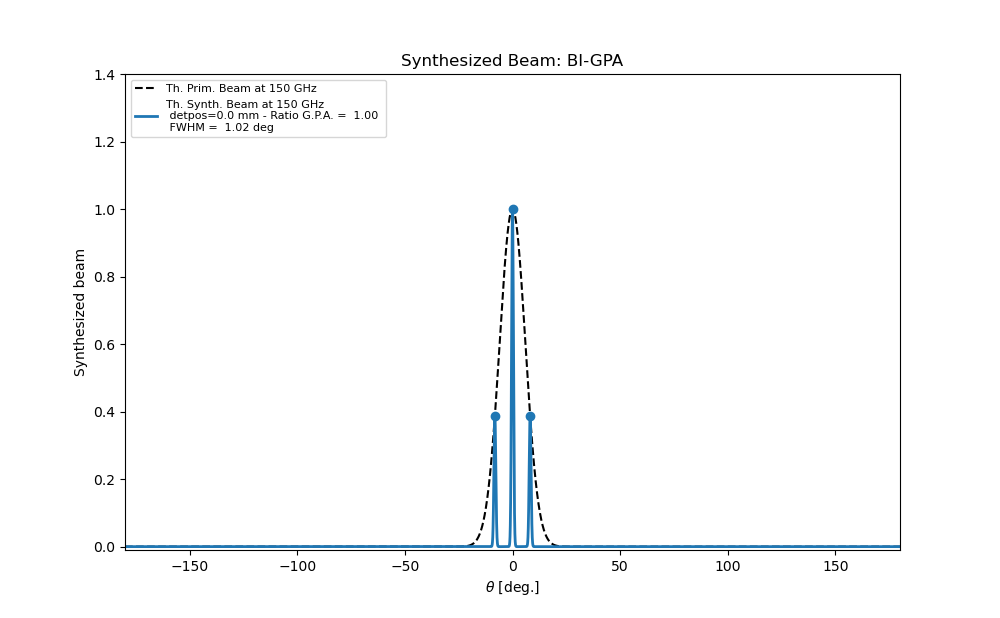

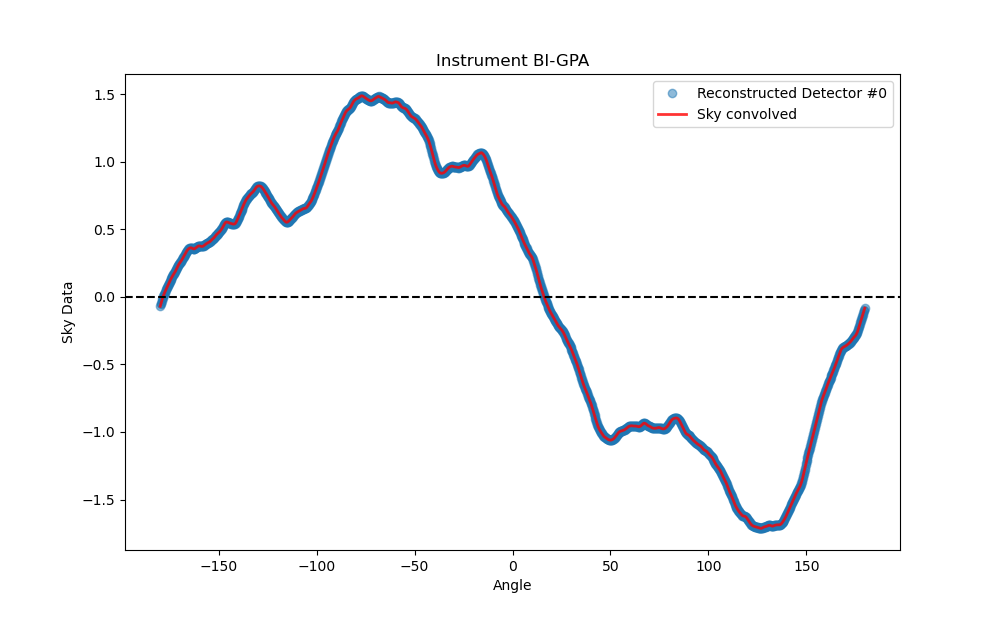

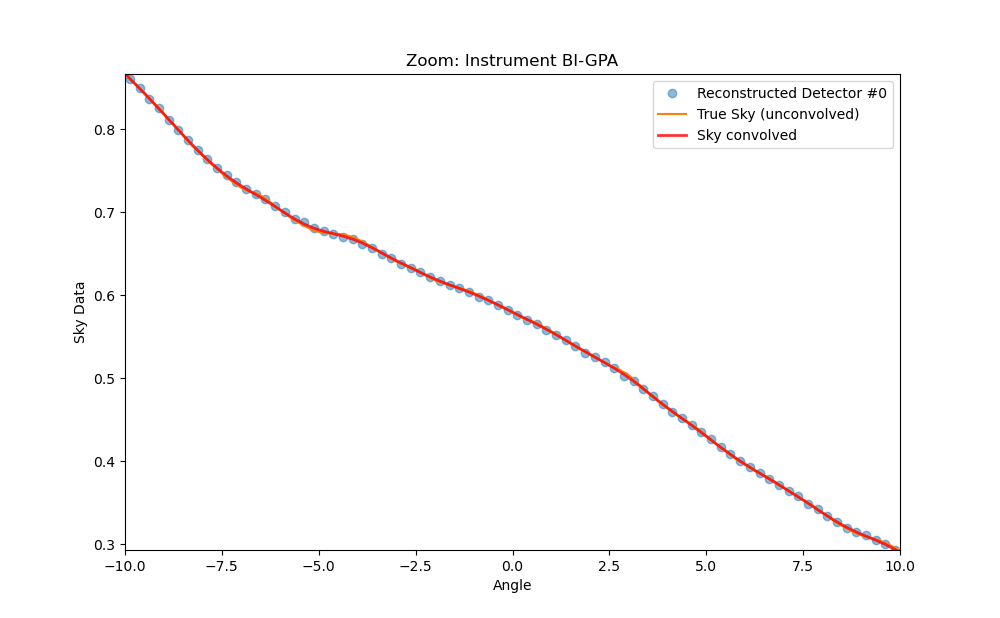

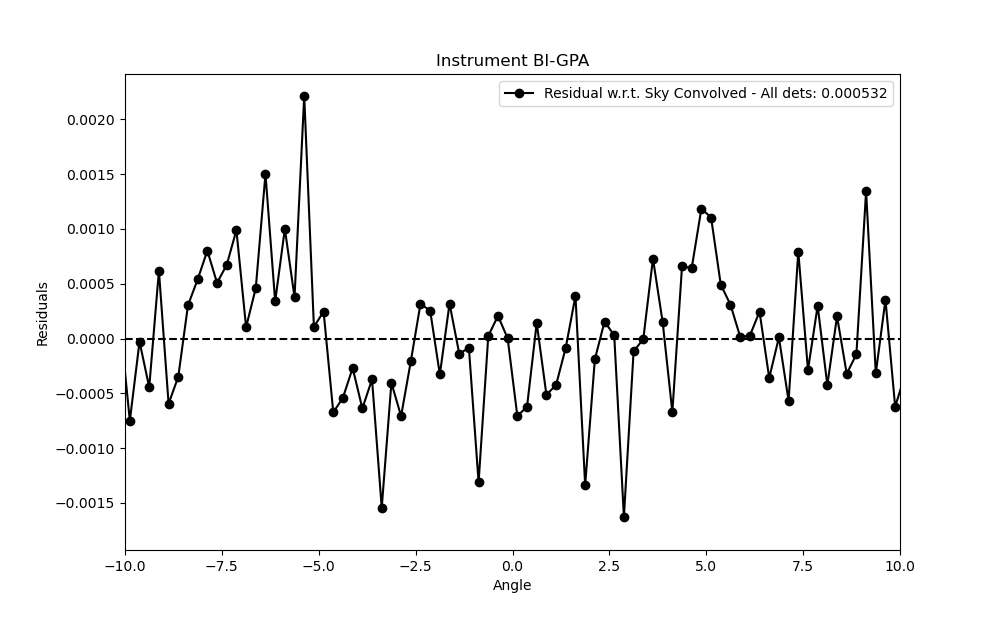

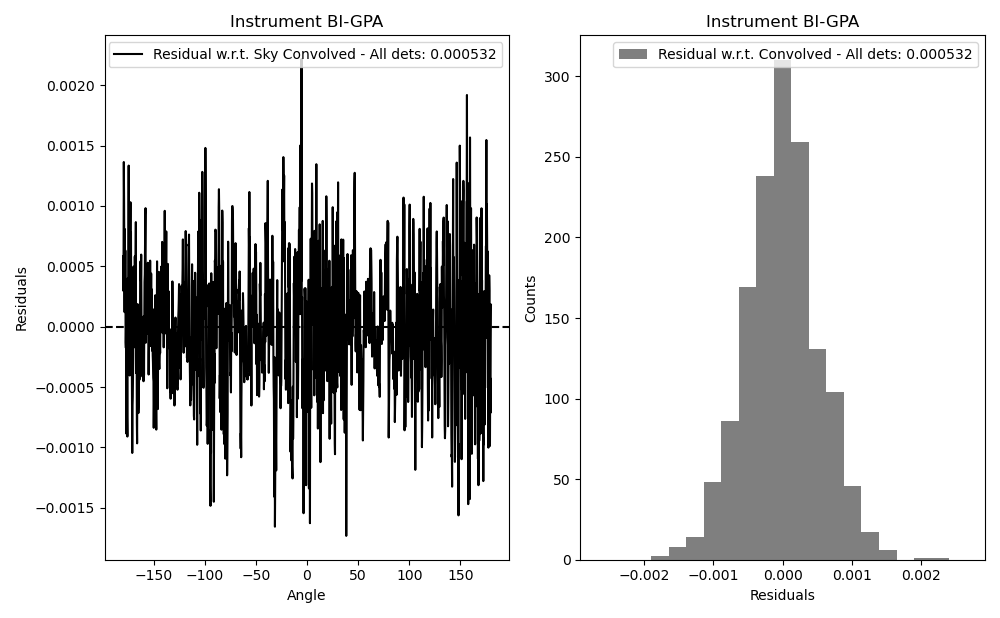

In [294]:
# Parameters
params = {}
# Sky Description #####################################################################
params['npix_sky']           = 2**15                # Number of pixels for the sky creation
params['sky_model']          = [rnd_sky_1d, 1.8]    # Model to randomly draw the sky: here power law in fourier space with index
# params['sky_model']          = [sinsky, 5.]         # Model to randomly draw the sky: here sinewave
params['sky_input']          = 'Bconv'              # DO we account for pixel window in the input or not either 'Bconv' or 'BWconv'
# Pointings ###########################################################################
params['npointings']         = 50000                # Number of pointings (uniformly drawn over 360 deg)
# Instrument ##########################################################################
params['instrument_type']    = 'BI-GPA'             # Instrument type: among ['BI', 'BI-GPA', 'Imager']
params['detpos']             = np.array([0.])       # Position of detectors
params['fwhmprim_150']       = 14.                  # in degrees
params['nu']                 = 150e9                # in Hz
params['dist_horns']         = 14.e-3               # distance between horns in meters
params['sqnh']               = 8                    # square root of the number of horns (square array of horns assumed)
params['Df']                 = 1.                   # focal distance in meters
params['kmax_build']         = 1                    # kmax for BI synthesized beam at the TOD fabrication stage
params['ntheta']             = 2**15+1              # number of samples for synthesized beam
params['minmaxtheta']        = 180                  # range for synthesized beam theta if set to X then it is [-X, X] in degrees
# noise ################################################################################
params['noise_rms']          = 0.                   # RMS noise per time sample
# Sky Recnstruction ####################################################################
params['npix']               = 360*4                # Number of reconstructed pixels
params['kmax_rec']           = params['kmax_build'] # kmax for BI synthesized beam at map-making stage
# Seeds ################################################################################
params['sky_seed']           = 1                    # Seed for the sky simulation
params['pointing_seed']      = 1                    # Seed for the pointing
params['noise_seed']         = None                 # Seed for the noise
# Plottings ############################################################################
params['plot_sky']           = False
params['plot_sb']            = True
params['plot_expected']      = False
params['plot_pointings']     = False
params['plot_TOD']           = False
params['plot_reconstructed'] = True


#### Show possible synthesized beam
th = np.linspace(-params['minmaxtheta'], params['minmaxtheta'], params['ntheta'])    # theta values in degrees for synthesized beam
params_temp = params.copy()
params_temp['plot_sb'] = False
_ = prepare_synthesized_beam(th, params_temp)


#### Reconstruct one
### Run all
pix_center, solution, solution_all, Ctruth_pix, xpix, truey, RMSresall, sb_description, H, HtH = run_1d_simulation(params)
print(RMSresall)

In [295]:
print('angular distance')
print(-130.50910651--122.32399515, -129.86051499--121.67540363)
print(-130.50910651--138.69421787, -129.86051499--138.04562635)
print()
print('pixel numbers (float)')
print((-122.32399515+180)/360 * 180, (-121.67540363+180)/360 * 180)
print((-130.50910651+180)/360 * 180, (-129.86051499+180)/360 * 180)
print((-138.69421787+180)/360 * 180, (-138.04562635+180)/360 * 180)
print()
print('pixel numbers (int)')
print(np.floor((-122.32399515+180)/360 * 180), np.floor((-121.67540363+180)/360 * 180))
print(np.floor((-130.50910651+180)/360 * 180), np.floor((-129.86051499+180)/360 * 180))
print(np.floor((-138.69421787+180)/360 * 180), np.floor((-138.04562635+180)/360 * 180))
print()
print('ptg distance')
print(-122.32399515 - -121.67540363)
print(-130.50910651 - -129.86051499)
print(-138.69421787 - -138.04562635)

angular distance
-8.185111360000008 -8.185111360000008
8.18511135999998 8.18511135999998

pixel numbers (float)
28.838002425 29.162298184999997
24.745446745 25.069742504999994
20.652891065000006 20.977186825000004

pixel numbers (int)
28.0 29.0
24.0 25.0
20.0 20.0

ptg distance
-0.6485915199999965
-0.6485915199999965
-0.6485915199999965


In [296]:
print(sb_description[2])

[-8.18511136  0.          8.18511136]


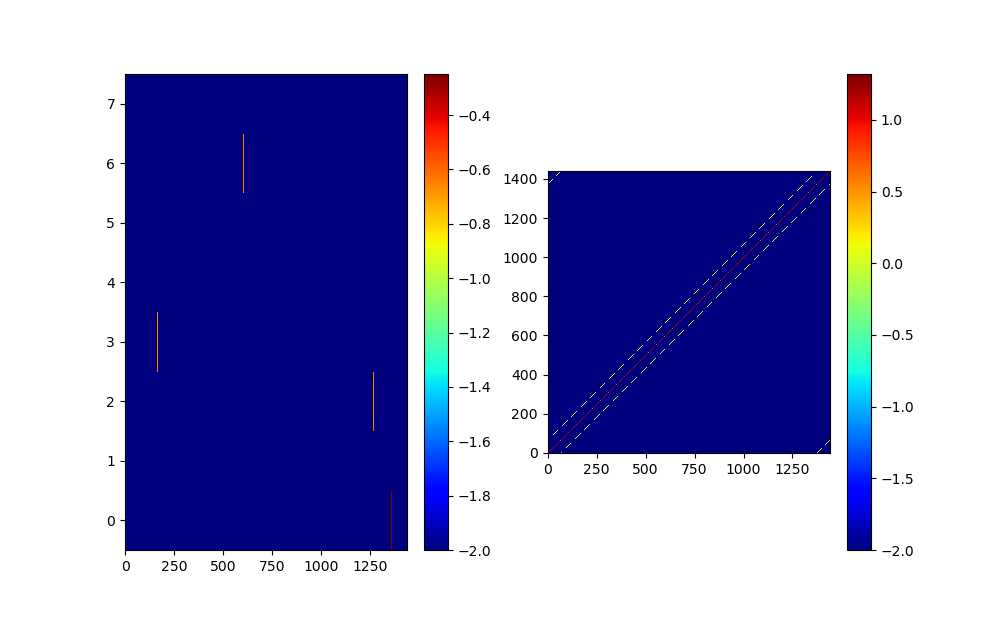

In [297]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.log10(H[0,68:76,:]+1e-2), 
            origin='lower', aspect='auto', interpolation='nearest',
            vmin=-2, vmax=np.log10(np.max(H)))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.log10(HtH[0,:,:]+1e-2), origin='lower', interpolation='nearest',
            vmin=-2, vmax=np.log10(np.max(HtH)))
plt.colorbar()


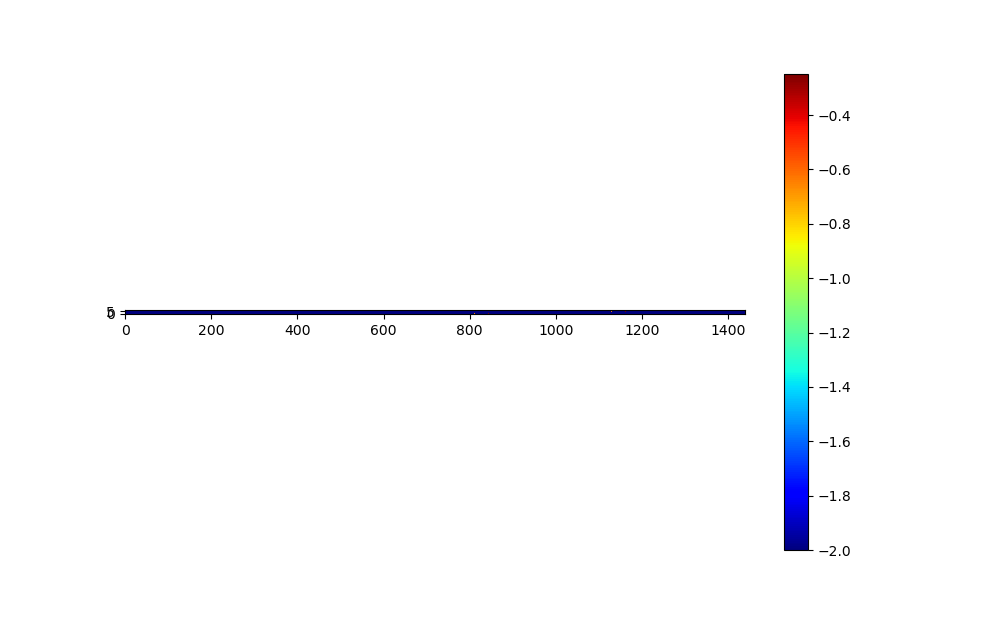

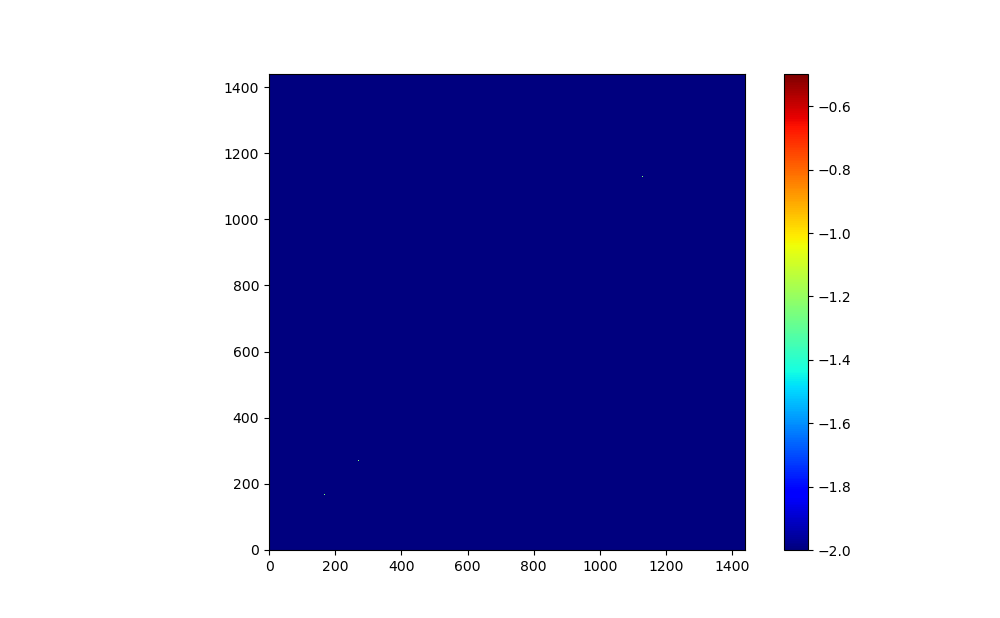

In [298]:
myH = H[0,68:76,:]
myHtH = myH.T @ myH

plt.figure()
plt.imshow(np.log10(myH+1e-2), origin='lower', interpolation='nearest',
            vmin=-2, vmax=np.log10(np.max(myH)))
plt.colorbar()

plt.figure()
plt.imshow(np.log10(myHtH+1e-2), origin='lower', interpolation='nearest',
            vmin=-2, vmax=np.log10(np.max(myHtH)))
plt.colorbar()


In [299]:
#### FFT Analysis
params['plot_sb']            = False
params['plot_reconstructed'] = False
params['sky_seed']           = 1                    # Seed for the sky simulation
params['pointing_seed']      = None                 # Seed for the pointing

nn = 10
plotall = False

all_ps_sky = np.zeros((nn, params['npix_sky']))
all_ps_sky_pix = np.zeros((nn, params['npix']))
all_ps_solution = np.zeros((nn, params['npix']))


for i in range(nn):
    pix_center, solution, solution_all, Ctruth_pix, xpix, truey, RMSresall, sb_description, H, HtH = run_1d_simulation(params)
    print(i, RMSresall)
    
    freq_pix = np.abs(np.fft.fftfreq(len(pix_center), d=pix_center[1]-pix_center[0]))
    all_ps_sky_pix[i,:] = np.abs(np.fft.fft(Ctruth_pix))**2 / len(Ctruth_pix)**2
    all_ps_solution[i,:] = np.abs(np.fft.fft(solution_all))**2  / len(Ctruth_pix) **2

    freq_sky = np.abs(np.fft.fftfreq(len(xpix), d=xpix[1]-xpix[0]))
    all_ps_sky[i,:] = np.abs(np.fft.fft(truey))**2 / len(xpix)**2
    
    if plotall:
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(freq_sky, all_ps_sky[i,:], label='Input Sky', alpha=0.3)
        plt.plot(freq_pix, all_ps_sky_pix[i,:], alpha=0.5, label='Expected Pixelized Sky')
        plt.plot(freq_pix, all_ps_solution[i,:], 'x', alpha=0.5, label='Solution')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Freq [$deg^{-1}$]')
        plt.ylabel('Power Spectrum')
        plt.ylim(1e-15, 1e0)
        plt.legend()
        
        plt.subplot(2,1,2)
        plt.plot(freq_pix, ps_solution / ps_sky_pix, label='Transfer fuction')
        plt.axhline(y=1, ls=':', color='k')
        plt.xscale('log')
        plt.xlabel('Freq [$deg^{-1}$]')
        plt.ylabel('Power Spectrum')
        plt.ylim(0.7,1.5)
        plt.legend()
        plt.tight_layout()



Sum of all peaks:  1.7752501328457773
0 [143.66703043 -62.87476559] [1294  468] 0.21834954931196904
1 [135.48191907 -71.05987694] [1261  435] 0.5633009013760619
2 [127.29680771 -79.2449883 ] [1229  403] 0.21834954931196904
0 0.0005372357945163393
Sum of all peaks:  1.7752501328457773
0 [140.12256497  58.88311838] [1280  955] 0.21834954931196904
1 [131.93745361  50.69800702] [1247  922] 0.5633009013760619
2 [123.75234225  42.51289566] [1215  890] 0.21834954931196904
1 0.0005350286828504689
Sum of all peaks:  1.7752501328457773
0 [171.09672378 -36.62271975] [1404  573] 0.21834954931196904
1 [162.91161242 -44.80783111] [1371  540] 0.5633009013760619
2 [154.72650106 -52.99294246] [1338  508] 0.21834954931196904
2 0.0005434886322109035
Sum of all peaks:  1.7752501328457773
0 [167.76149102 142.30638435] [1391 1289] 0.21834954931196904
1 [159.57637966 134.12127299] [1358 1256] 0.5633009013760619
2 [151.3912683  125.93616163] [1325 1223] 0.21834954931196904
3 0.0005673351363928507
Sum of all p

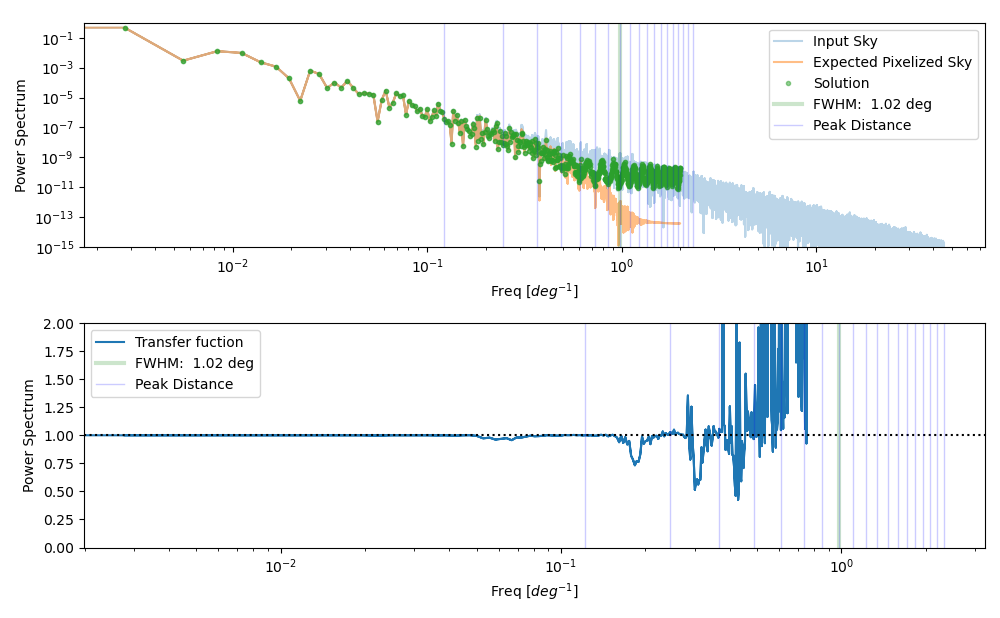

In [301]:
fwhmpeaks = sb_description[0]
amppeaks = sb_description[1]
thetapeaks = sb_description[2]


known_freqs = []
known_freqs.append({'label':'FWHM: {0:5.3g} deg'.format(fwhmpeaks), 'freq': 1./(fwhmpeaks), 'color':'g', 'ls':'-', 'lw': 3, 'nbharm': 1})
known_freqs.append({'label':'Peak Distance', 'freq': np.abs(1./(thetapeaks[1]-thetapeaks[0])), 'color':'b', 'ls':'-', 'lw':1, 'nbharm': 20 })
# known_freqs.append({'label':'Diag Peak Distance', 'freq': np.abs(1./(thetapeaks[1]-thetapeaks[0]))/np.sqrt(2), 'color':'r' })
#known_freqs.append({'label':'Primary Beam', 'freq': 1./params['fwhmprim_150'], 'color':'m' })

# ftest = 1./params['fwhmprim_150']
# mylabel = 'Primary beam'


aa = 0.2
harm_max=50

plt.figure()
plt.subplot(2,1,1)
plt.plot(freq_sky, np.mean(all_ps_sky, axis=0), label='Input Sky', alpha=0.3)
plt.plot(freq_pix, np.mean(all_ps_sky_pix, axis=0), alpha=0.5, label='Expected Pixelized Sky')
plt.plot(freq_pix, np.mean(all_ps_solution, axis=0), '.', alpha=0.5, label='Solution')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Power Spectrum')
plt.ylim(1e-15, 1e0)
plt.legend()

plt.subplot(2,1,2)
plt.plot(freq_pix, np.mean(all_ps_solution, axis=0) / np.mean(all_ps_sky_pix, axis=0), label='Transfer fuction')
plt.axhline(y=1, ls=':', color='k')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.xscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Power Spectrum')
plt.ylim(0.,2.)
plt.legend()
plt.tight_layout()




Ideas:

- [Tom] effect of intercalibration / normalization of peaks
- [Tom] check that peaks near the edge actually are well placed on the other side with the modulo

Tested:
- Extension of theta range for SB => it does improve a lot the situation but not completely
  - for now I've set to 180 => the whole range...
- [Alexandre] number of peaks in building / reconstructing (-180, 180 for SB).
  - there was indeed an issue related to the extension in theta: some of the peaks were not accounted for at TOD pabrication but accouted for at reconstruction
- [Tom] there are other factors in peak amplitude in the code, see message in Rocket Chat
  - putting similar factor lead to significant differences in the peak normaliztion.
  - Not fully checked, but seems a bit unlikely...

In [291]:
fwhmpeaks/2.35

0.4353782637772213

In [124]:
pix_center[1]-pix_center[0]

0.25